In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([[0], [0], [255], [0.35]])
        # color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [9]:
image = cv2.imread('defect/images/plane_1.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

device = "cuda"

sam_checkpoint = "weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"
image.shape


(420, 560, 3)

In [10]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image)
print(len(masks))
print(masks[0].keys())

33
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


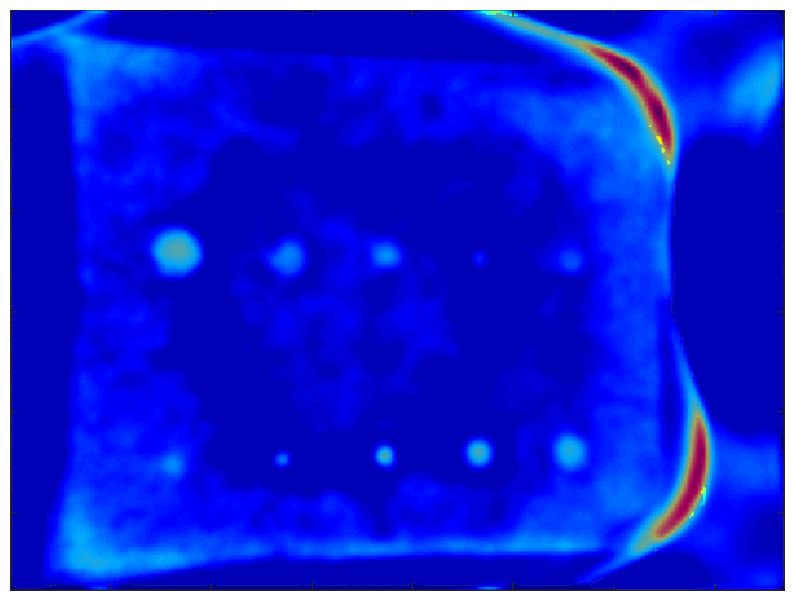

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

['defect/data/mat/plane/20200813_0005g.mat', 'defect/data/mat/plane/20200923_0006g.mat', 'defect/data/mat/plane/20200723_0037g.mat', 'defect/data/mat/plane/20200813_0001g.mat', 'defect/data/mat/plane/20200618_0117g.mat', 'defect/data/mat/plane/20200723_0040g.mat', 'defect/data/mat/plane/20200618_0115g.mat', 'defect/data/mat/plane/20200723_0049g.mat', 'defect/data/mat/plane/20200812_0012g.mat', 'defect/data/mat/plane/166g.mat', 'defect/data/mat/r_zone/036g.mat', 'defect/data/mat/r_zone/029g.mat', 'defect/data/mat/r_zone/035g.mat', 'defect/data/mat/r_zone/012g.mat', 'defect/data/mat/temperature/J18.mat', 'defect/data/mat/temperature/NT.mat', 'defect/data/mat/temperature/N3.mat', 'defect/data/mat/temperature/N2.mat']
defect/data/labels/20200813_0005g_label.png
(23, 512, 512, 3) (23, 512, 512, 3)


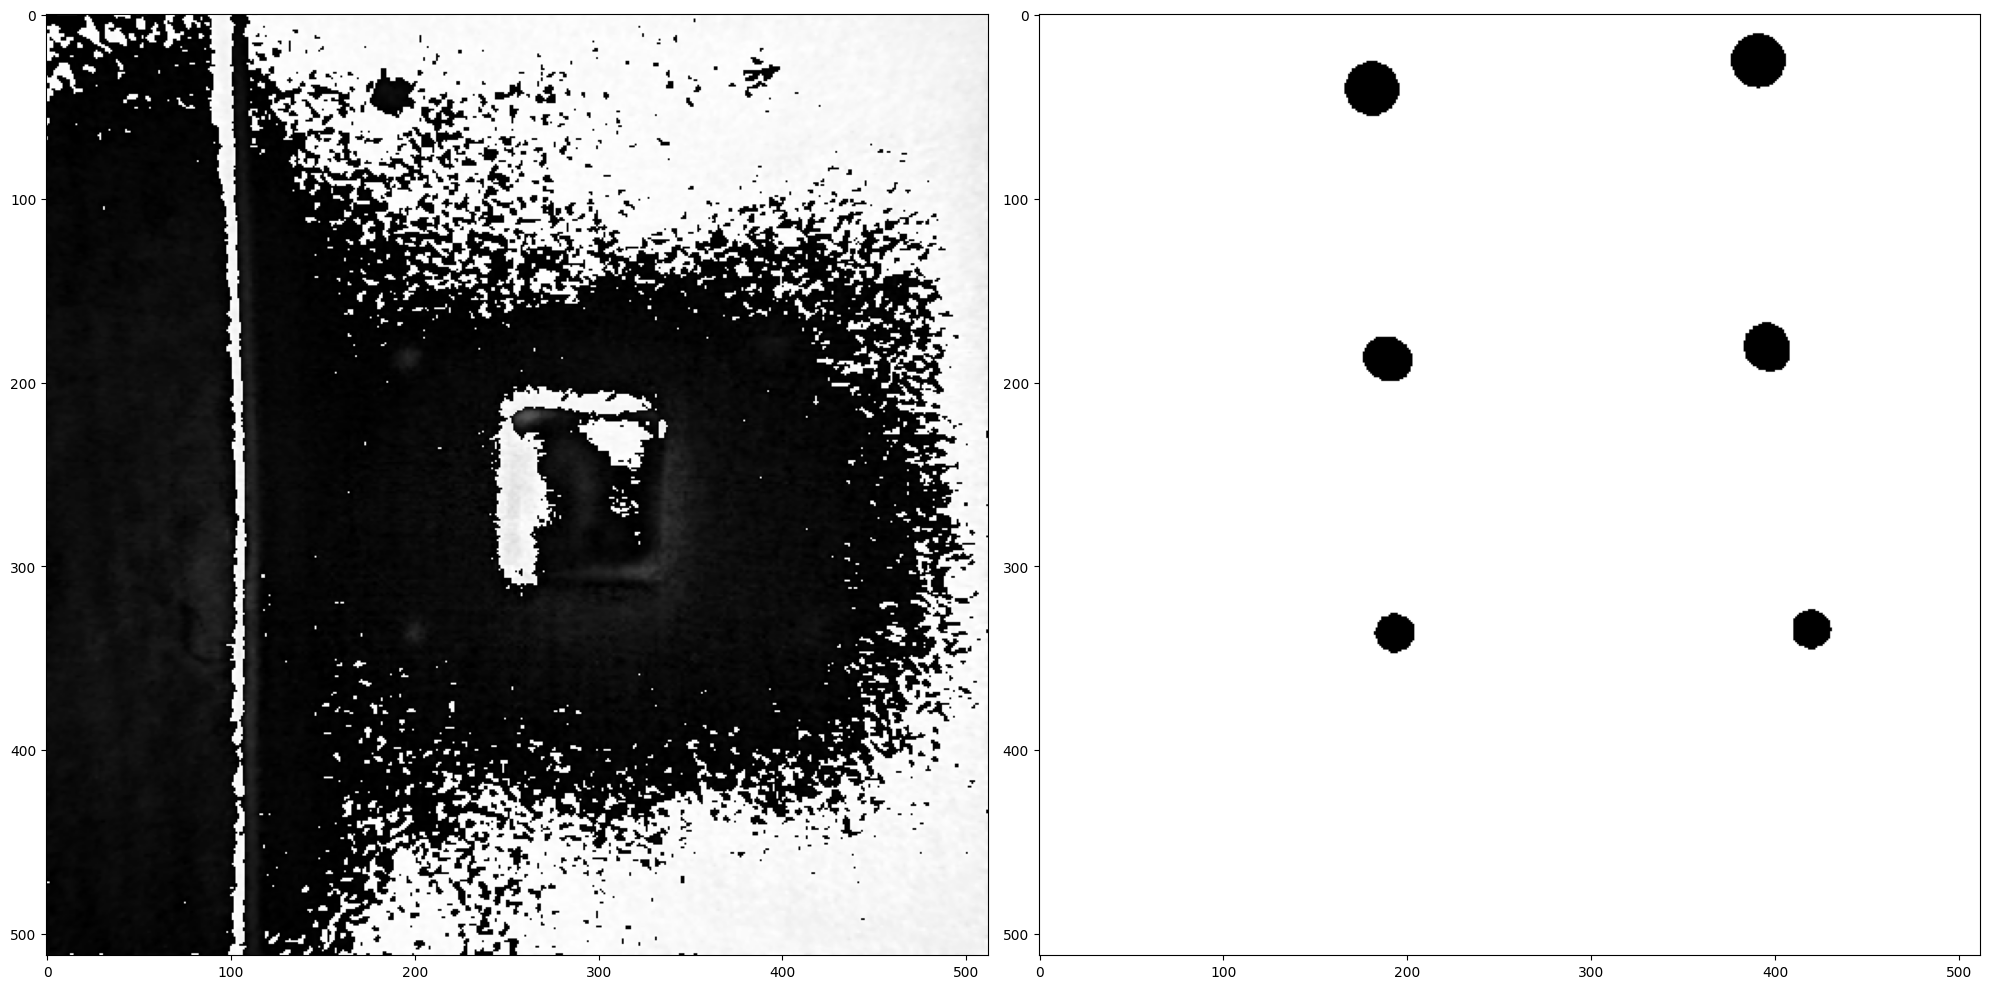

In [42]:
import os
import scipy.io as sio
height, width = 512, 512
file = open('defect/test_set.txt', 'r')
test_set = [line.strip() for line in file]
label_dir = 'defect/data/labels'
# 关闭文件
file.close()
heating_num = 50
sample_rate = 5

def one_data_process_plane2D(file_path):
    basename = file_path.split('/')[-1].split('.')[0]
    label_path = os.path.join(label_dir,'{}_label.png'.format(basename))
    print(label_path)
    label_img = cv2.imread(label_path)
    label_img = cv2.resize(label_img, (height, width))
    # label_img = label_img.astype(np.float32) / 255.
    label_img[label_img < 120] = 0
    label_img[label_img != 0 ] = 255

    data_struct = sio.loadmat(file_path)
    data = data_struct['data']

    t_len = data.shape[2]
    sub = data[:, :, -1]
    # sub = sub.astype(np.float32) / 255.
    data = data[:, :, heating_num:min(t_len, heating_num+160)]
    # data = data.astype(np.float32) / 255.
    data = data - np.tile(sub[:, :, np.newaxis], (1, 1, data.shape[2]))

    data = data[:, :, ::sample_rate]
    data = cv2.resize(data, (height, width))
    data = np.transpose(data, (2, 0, 1))

    labels = np.tile(label_img[np.newaxis, :, :, :], (data.shape[0], 1, 1, 1))
    data = np.tile(data[:, :, :, np.newaxis], (1, 1, 1, 3))

    print(data.shape, labels.shape)
    # return data, labels
    return data.astype(np.uint8), labels.astype(np.uint8)

print(test_set)    
for file_path in test_set[0:1]:
    data, labels = one_data_process_plane2D(file_path)
    fig, ax = plt.subplots(1, 2, figsize=(20, 20))
    ax[0].imshow(data[10])
    ax[1].imshow(labels[10])
    plt.tight_layout()
    plt.show()


In [43]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

for file_path in test_set[0:1]:
    data, labels = one_data_process_plane2D(file_path)
    for i in range(data.shape[0]):
        
        masks = mask_generator.generate(data[i])
        print(masks)
        break



defect/data/labels/20200813_0005g_label.png
(23, 512, 512, 3) (23, 512, 512, 3)
[{'segmentation': array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]]), 'area': 47470, 'bbox': [0, 0, 94, 511], 'predicted_iou': 1.017224907875061, 'point_coords': [[8.0, 24.0]], 'stability_score': 0.9925236701965332, 'crop_box': [0, 0, 512, 512]}, {'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 

In [47]:
label_temp = labels[i][:, :, 0]
label_temp = label_temp == 0
print(label_temp.sum())

segmentation = np.zeros((height, width), dtype=bool)
for ann in masks:
    segmentation = np.logical_or(segmentation, ann['segmentation'])
print(segmentation.sum())
intersection = np.logical_and(segmentation, label_temp).sum()
union = np.logical_or(segmentation, label_temp).sum()
iou = intersection / (union + 1e-8)
print(iou)


3133
232018
0.010532874946282314
